### <center>Libraries and Configs</center>

In [1]:
# Import libraries
import os
from glob import glob
import json
import pandas as pd
pd.set_option('display.max_columns', None)
import polars as pl
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns 

In [2]:
# Declare dataset configs
dataset_configs = {
    'train_metadata_path': r'..\datasets\train.csv',
    'train_tracking_dir_path': r'..\datasets\train_tracking',
    'train_annotation_dir_path': r'..\datasets\train_annotation',
    'test_metadata_path': r'..\datasets\test.csv',
    'test_tracking_dir_path': r'..\datasets\test_tracking',
    'sample_submission_file_path': r'..\datasets\sample_submission.csv'
}

### <center>Filter Data</center>

In [3]:
# Get all tracking and annotation files (recursive)
tracking_files = glob(os.path.join(dataset_configs['train_tracking_dir_path'], '**', '*.parquet'), recursive=True)
annotation_files = glob(os.path.join(dataset_configs['train_annotation_dir_path'], '**', '*.parquet'), recursive=True)
print("Number of tracking files:", len(tracking_files))
print("Number of annotation files:", len(annotation_files))


Number of tracking files: 8789
Number of annotation files: 847


In [4]:
# Get file ids with both tracking and annotation files
tracking_file_ids = {os.path.splitext(os.path.basename(f))[0] for f in tracking_files}
annotation_file_ids = {os.path.splitext(os.path.basename(f))[0] for f in annotation_files}
valid_video_ids = tracking_file_ids.intersection(annotation_file_ids)
valid_video_ids = [int(vid) for vid in valid_video_ids]
print("Number of valid video ids with both tracking and annotation files:", len(valid_video_ids))

Number of valid video ids with both tracking and annotation files: 847


In [5]:
# Read metadata file
metadata_df = pd.read_csv(dataset_configs['train_metadata_path'])
metadata_df.head()

,lab_id,video_id,mouse1_strain,mouse1_color,mouse1_sex,mouse1_id,mouse1_age,mouse1_condition,mouse2_strain,mouse2_color,mouse2_sex,mouse2_id,mouse2_age,mouse2_condition,mouse3_strain,mouse3_color,mouse3_sex,mouse3_id,mouse3_age,mouse3_condition,mouse4_strain,mouse4_color,mouse4_sex,mouse4_id,mouse4_age,mouse4_condition,frames_per_second,video_duration_sec,pix_per_cm_approx,video_width_pix,video_height_pix,arena_width_cm,arena_height_cm,arena_shape,arena_type,body_parts_tracked,behaviors_labeled,tracking_method
0,AdaptableSnail,44566106,CD-1 (ICR),white,male,10.0,8-12 weeks,wireless device,CD-1 (ICR),white,male,24.0,8-12 weeks,wireless device,CD-1 (ICR),white,male,38.0,8-12 weeks,wireless device,CD-1 (ICR),white,male,51.0,8-12 weeks,wireless device,30.0,615.6,16.0,1228,1068,60.0,60.0,square,familiar,"[""body_center"", ""ear_left"", ""ear_right"", ""head...","[""mouse1,mouse2,approach"", ""mouse1,mouse2,atta...",DeepLabCut
1,AdaptableSnail,143861384,CD-1 (ICR),white,male,3.0,8-12 weeks,NaN,CD-1 (ICR),white,male,17.0,8-12 weeks,NaN,CD-1 (ICR),white,male,31.0,8-12 weeks,NaN,CD-1 (ICR),white,male,44.0,8-12 weeks,NaN,25.0,3599.0,9.7,968,608,60.0,60.0,square,familiar,"[""body_center"", ""ear_left"", ""ear_right"", ""late...","[""mouse1,mouse2,approach"", ""mouse1,mouse2,atta...",DeepLabCut
2,AdaptableSnail,209576908,CD-1 (ICR),white,male,7.0,8-12 weeks,NaN,CD-1 (ICR),white,male,21.0,8-12 weeks,NaN,CD-1 (ICR),white,male,35.0,8-12 weeks,NaN,CD-1 (ICR),white,male,48.0,8-12 weeks,NaN,30.0,615.2,16.0,1266,1100,60.0,60.0,square,familiar,"[""body_center"", ""ear_left"", ""ear_right"", ""late...","[""mouse1,mouse2,approach"", ""mouse1,mouse2,atta...",DeepLabCut
3,AdaptableSnail,278643799,CD-1 (ICR),white,male,11.0,8-12 weeks,wireless device,CD-1 (ICR),white,male,25.0,8-12 weeks,wireless device,CD-1 (ICR),white,male,39.0,8-12 weeks,wireless device,NaN,NaN,NaN,NaN,NaN,NaN,30.0,619.7,16.0,1224,1100,60.0,60.0,square,familiar,"[""body_center"", ""ear_left"", ""ear_right"", ""head...","[""mouse1,mouse2,approach"", ""mouse1,mouse2,atta...",DeepLabCut
4,AdaptableSnail,351967631,CD-1 (ICR),white,male,14.0,8-12 weeks,NaN,CD-1 (ICR),white,male,28.0,8-12 weeks,NaN,CD-1 (ICR),white,male,42.0,8-12 weeks,NaN,NaN,NaN,NaN,NaN,8-12 weeks,NaN,30.0,602.6,16.0,1204,1068,60.0,60.0,square,familiar,"[""body_center"", ""ear_left"", ""ear_right"", ""late...","[""mouse1,mouse2,approach"", ""mouse1,mouse2,atta...",DeepLabCut


In [6]:
# Filter out only valid metadata
metadata_df = metadata_df[metadata_df['video_id'].isin(valid_video_ids)].reset_index(drop=True)
print("Filtered metadata shape:", metadata_df.shape)
metadata_df.head()

Filtered metadata shape: (847, 38)


,lab_id,video_id,mouse1_strain,mouse1_color,mouse1_sex,mouse1_id,mouse1_age,mouse1_condition,mouse2_strain,mouse2_color,mouse2_sex,mouse2_id,mouse2_age,mouse2_condition,mouse3_strain,mouse3_color,mouse3_sex,mouse3_id,mouse3_age,mouse3_condition,mouse4_strain,mouse4_color,mouse4_sex,mouse4_id,mouse4_age,mouse4_condition,frames_per_second,video_duration_sec,pix_per_cm_approx,video_width_pix,video_height_pix,arena_width_cm,arena_height_cm,arena_shape,arena_type,body_parts_tracked,behaviors_labeled,tracking_method
0,AdaptableSnail,44566106,CD-1 (ICR),white,male,10.0,8-12 weeks,wireless device,CD-1 (ICR),white,male,24.0,8-12 weeks,wireless device,CD-1 (ICR),white,male,38.0,8-12 weeks,wireless device,CD-1 (ICR),white,male,51.0,8-12 weeks,wireless device,30.0,615.6,16.0,1228,1068,60.0,60.0,square,familiar,"[""body_center"", ""ear_left"", ""ear_right"", ""head...","[""mouse1,mouse2,approach"", ""mouse1,mouse2,atta...",DeepLabCut
1,AdaptableSnail,143861384,CD-1 (ICR),white,male,3.0,8-12 weeks,NaN,CD-1 (ICR),white,male,17.0,8-12 weeks,NaN,CD-1 (ICR),white,male,31.0,8-12 weeks,NaN,CD-1 (ICR),white,male,44.0,8-12 weeks,NaN,25.0,3599.0,9.7,968,608,60.0,60.0,square,familiar,"[""body_center"", ""ear_left"", ""ear_right"", ""late...","[""mouse1,mouse2,approach"", ""mouse1,mouse2,atta...",DeepLabCut
2,AdaptableSnail,209576908,CD-1 (ICR),white,male,7.0,8-12 weeks,NaN,CD-1 (ICR),white,male,21.0,8-12 weeks,NaN,CD-1 (ICR),white,male,35.0,8-12 weeks,NaN,CD-1 (ICR),white,male,48.0,8-12 weeks,NaN,30.0,615.2,16.0,1266,1100,60.0,60.0,square,familiar,"[""body_center"", ""ear_left"", ""ear_right"", ""late...","[""mouse1,mouse2,approach"", ""mouse1,mouse2,atta...",DeepLabCut
3,AdaptableSnail,278643799,CD-1 (ICR),white,male,11.0,8-12 weeks,wireless device,CD-1 (ICR),white,male,25.0,8-12 weeks,wireless device,CD-1 (ICR),white,male,39.0,8-12 weeks,wireless device,NaN,NaN,NaN,NaN,NaN,NaN,30.0,619.7,16.0,1224,1100,60.0,60.0,square,familiar,"[""body_center"", ""ear_left"", ""ear_right"", ""head...","[""mouse1,mouse2,approach"", ""mouse1,mouse2,atta...",DeepLabCut
4,AdaptableSnail,351967631,CD-1 (ICR),white,male,14.0,8-12 weeks,NaN,CD-1 (ICR),white,male,28.0,8-12 weeks,NaN,CD-1 (ICR),white,male,42.0,8-12 weeks,NaN,NaN,NaN,NaN,NaN,8-12 weeks,NaN,30.0,602.6,16.0,1204,1068,60.0,60.0,square,familiar,"[""body_center"", ""ear_left"", ""ear_right"", ""late...","[""mouse1,mouse2,approach"", ""mouse1,mouse2,atta...",DeepLabCut


### <center>Data Preparation</center>

In [7]:
# Create a map of video id and labels
actions = {}
for idx, row in metadata_df.iterrows():
    lab_id, video_id = row['lab_id'],row['video_id']
    annotation_df = pd.read_parquet(os.path.join(dataset_configs['train_annotation_dir_path'], lab_id, f"{video_id}.parquet"))
    for action in annotation_df['action'].unique():
        if action not in actions:
            actions[action] = [video_id]
        else:
            actions[action].append(video_id)

print("Actions found: ")
for action, vids in actions.items():
    print(f"Action: {action}, Number of videos: {len(vids)}")

os.makedirs('dumps', exist_ok=True)
with open('dumps/action_video_map.json', 'w') as f:
    json.dump(actions, f, indent=4)

Actions found: 
Action: rear, Number of videos: 85
Action: avoid, Number of videos: 17
Action: attack, Number of videos: 332
Action: approach, Number of videos: 159
Action: chase, Number of videos: 60
Action: submit, Number of videos: 9
Action: chaseattack, Number of videos: 13
Action: shepherd, Number of videos: 8
Action: sniff, Number of videos: 594
Action: mount, Number of videos: 247
Action: disengage, Number of videos: 20
Action: selfgroom, Number of videos: 81
Action: sniffgenital, Number of videos: 405
Action: sniffface, Number of videos: 108
Action: sniffbody, Number of videos: 109
Action: dominancemount, Number of videos: 63
Action: attemptmount, Number of videos: 42
Action: intromit, Number of videos: 81
Action: genitalgroom, Number of videos: 17
Action: reciprocalsniff, Number of videos: 21
Action: escape, Number of videos: 93
Action: dominance, Number of videos: 6
Action: allogroom, Number of videos: 17
Action: ejaculate, Number of videos: 3
Action: defend, Number of videos

In [8]:
# Agent and target are same
action_to_itself = {}
for idx, row in tqdm(metadata_df.iterrows(), total=metadata_df.shape[0], desc="Checking actions where agent and target is same"):
    lab_id, video_id = row['lab_id'],row['video_id']
    annotation_df = pd.read_parquet(os.path.join(dataset_configs['train_annotation_dir_path'], lab_id, f"{video_id}.parquet"))
    for _, ann_row in annotation_df.iterrows():
        if ann_row['agent_id'] == ann_row['target_id']:
            action = ann_row['action']
            if action not in action_to_itself:
                action_to_itself[action] = [video_id]
            else:
                if video_id not in action_to_itself[action]:
                    action_to_itself[action].append(video_id)

print("Actions where agent and target are same: ")
for action, vids in action_to_itself.items():
    print(f"Action: {action}, Number of videos: {len(vids)}")

os.makedirs('dumps', exist_ok=True)
with open('dumps/action_to_itself_video_map.json', 'w') as f:
    json.dump(action_to_itself, f, indent=4)

Checking actions where agent and target is same: 100%|██████████| 847/847 [00:03<00:00, 226.84it/s]

Actions where agent and target are same: 
Action: rear, Number of videos: 85
Action: selfgroom, Number of videos: 81
Action: genitalgroom, Number of videos: 17
Action: climb, Number of videos: 20
Action: dig, Number of videos: 37
Action: rest, Number of videos: 13
Action: run, Number of videos: 11
Action: freeze, Number of videos: 9
Action: exploreobject, Number of videos: 10
Action: biteobject, Number of videos: 10
Action: huddle, Number of videos: 11


In [9]:
# Action and target are not same
action_to_others = {}
for idx, row in tqdm(metadata_df.iterrows(), total=metadata_df.shape[0], desc="Checking actions where agent and target are different"):
    lab_id, video_id = row['lab_id'],row['video_id']
    annotation_df = pd.read_parquet(os.path.join(dataset_configs['train_annotation_dir_path'], lab_id, f"{video_id}.parquet"))
    for _, ann_row in annotation_df.iterrows():
        if ann_row['agent_id'] != ann_row['target_id']:
            action = ann_row['action']
            if action not in action_to_others:
                action_to_others[action] = [video_id]
            else:
                if video_id not in action_to_others[action]:
                    action_to_others[action].append(video_id)

print("Actions where agent and target are different: ")
for action, vids in action_to_others.items():
    print(f"Action: {action}, Number of videos: {len(vids)}")

os.makedirs('dumps', exist_ok=True)
with open('dumps/action_to_others_video_map.json', 'w') as f:
    json.dump(action_to_others, f, indent=4)

Checking actions where agent and target are different: 100%|██████████| 847/847 [00:03<00:00, 214.35it/s]

Actions where agent and target are different: 
Action: avoid, Number of videos: 17
Action: attack, Number of videos: 332
Action: approach, Number of videos: 159
Action: chase, Number of videos: 60
Action: submit, Number of videos: 9
Action: chaseattack, Number of videos: 13
Action: shepherd, Number of videos: 8
Action: sniff, Number of videos: 594
Action: mount, Number of videos: 247
Action: disengage, Number of videos: 20
Action: sniffgenital, Number of videos: 405
Action: sniffface, Number of videos: 108
Action: sniffbody, Number of videos: 109
Action: dominancemount, Number of videos: 63
Action: attemptmount, Number of videos: 42
Action: intromit, Number of videos: 81
Action: reciprocalsniff, Number of videos: 21
Action: escape, Number of videos: 93
Action: dominance, Number of videos: 6
Action: allogroom, Number of videos: 17
Action: ejaculate, Number of videos: 3
Action: defend, Number of videos: 52
Action: dominancegroom, Number of videos: 14
Action: flinch, Number of videos: 11


Some actions are only done to itself while some actions can only be performed to others. So, the models should be built accordingly.

In [10]:
# Check agent or target is involved in multiple actions in same time frame
overlap_results = {}

for file in tqdm(annotation_files, desc="Checking overlaps in actions for agents and targets"):
    annotation_df = pd.read_parquet(file).reset_index().rename(columns={'index':'annotation_index'})
    file_id = os.path.basename(file).split('.')[0]  # use filename as file_id
    
    file_overlaps = []

    # --- Agent overlaps ---
    agent_overlap = (
        annotation_df.merge(annotation_df, on="agent_id", suffixes=("_1", "_2"))
        .query("annotation_index_1 < annotation_index_2")
        .query("action_1 != action_2")
        .query("start_frame_1 <= stop_frame_2 and start_frame_2 <= stop_frame_1")
    )
    if not agent_overlap.empty:
        for _, row in agent_overlap.iterrows():
            overlap_start = max(row.start_frame_1, row.start_frame_2)
            overlap_end = min(row.stop_frame_1, row.stop_frame_2)
            if overlap_start <= overlap_end:
                file_overlaps.append({
                    "type": "agent",
                    "id": row.agent_id,
                    "actions": sorted({row.action_1, row.action_2}),
                    "overlap_range": [overlap_start, overlap_end]
                })

    # --- Target overlaps ---
    target_overlap = (
        annotation_df.merge(annotation_df, on="target_id", suffixes=("_1", "_2"))
        .query("annotation_index_1 < annotation_index_2")
        .query("action_1 != action_2")
        .query("start_frame_1 <= stop_frame_2 and start_frame_2 <= stop_frame_1")
    )
    if not target_overlap.empty:
        for _, row in target_overlap.iterrows():
            overlap_start = max(row.start_frame_1, row.start_frame_2)
            overlap_end = min(row.stop_frame_1, row.stop_frame_2)
            if overlap_start <= overlap_end:
                file_overlaps.append({
                    "type": "target",
                    "id": row.target_id,
                    "actions": sorted({row.action_1, row.action_2}),
                    "overlap_range": [overlap_start, overlap_end]
                })

    if file_overlaps:
        overlap_results[file_id] = file_overlaps

overlap_results


Checking overlaps in actions for agents and targets: 100%|██████████| 847/847 [00:16<00:00, 50.48it/s]


{'1212811043': [{'type': 'agent',
   'id': 1,
   'actions': ['attack', 'chase'],
   'overlap_range': [24286, 24286]},
  {'type': 'target',
   'id': 4,
   'actions': ['attack', 'avoid'],
   'overlap_range': [24523, 24533]},
  {'type': 'target',
   'id': 2,
   'actions': ['attack', 'avoid'],
   'overlap_range': [26053, 26060]},
  {'type': 'target',
   'id': 1,
   'actions': ['attack', 'avoid'],
   'overlap_range': [26054, 26071]},
  {'type': 'target',
   'id': 4,
   'actions': ['attack', 'avoid'],
   'overlap_range': [54812, 54823]},
  {'type': 'target',
   'id': 2,
   'actions': ['attack', 'chase'],
   'overlap_range': [75514, 75515]}],
 '1260392287': [{'type': 'target',
   'id': 1,
   'actions': ['attack', 'avoid'],
   'overlap_range': [33436, 33500]},
  {'type': 'target',
   'id': 2,
   'actions': ['attack', 'avoid'],
   'overlap_range': [44255, 44276]},
  {'type': 'target',
   'id': 1,
   'actions': ['attack', 'avoid'],
   'overlap_range': [44255, 44276]}],
 '1351098077': [{'type': '

Therefore, a single agnet or target can involve in multiple actions in a single timestamp.

In [11]:
# Check bodyparts distribution
bodyparts_freq = {}
for file in tqdm(tracking_files, desc="Checking bodyparts distribution", total=len(tracking_files)):
    tracking_df = pd.read_parquet(file)
    freq_list = tracking_df['bodypart'].value_counts().to_dict()
    for bodypart, freq in freq_list.items():
        if bodypart not in bodyparts_freq:
            bodyparts_freq[bodypart] = freq
        else:
            bodyparts_freq[bodypart] += freq
bodyparts_freq


Checking bodyparts distribution: 100%|██████████| 8789/8789 [01:50<00:00, 79.46it/s] 


{'body_center': 60325975,
 'lateral_left': 7242893,
 'lateral_right': 7252270,
 'ear_left': 85265692,
 'ear_right': 85474738,
 'tail_base': 85539890,
 'tail_midpoint': 44533274,
 'nose': 84492288,
 'tail_tip': 49083970,
 'neck': 65870094,
 'headpiece_topfrontright': 627505,
 'headpiece_topfrontleft': 608567,
 'headpiece_topbackright': 616039,
 'headpiece_topbackleft': 601630,
 'headpiece_bottomfrontright': 563750,
 'headpiece_bottombackright': 544832,
 'headpiece_bottombackleft': 408156,
 'headpiece_bottomfrontleft': 291468,
 'hip_left': 23191683,
 'hip_right': 23301051,
 'head': 892516,
 'forepaw_left': 42800400,
 'forepaw_right': 42800400,
 'hindpaw_left': 42800400,
 'hindpaw_right': 42800400,
 'spine_1': 628714,
 'spine_2': 628714,
 'tail_middle_1': 628714,
 'tail_middle_2': 628714}

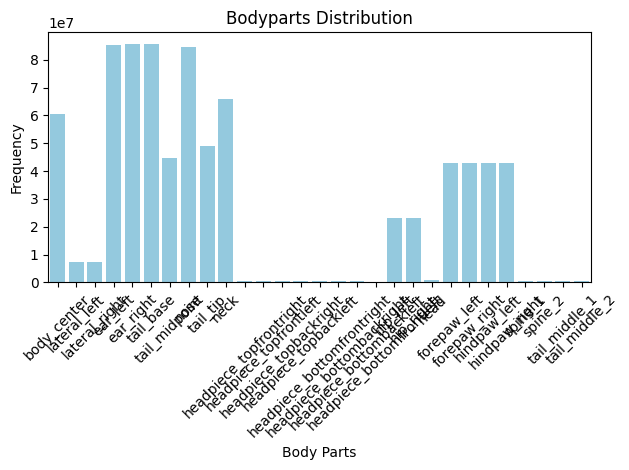

In [14]:
# PLot the bodyparts distribution
sns.barplot(
    x=list(bodyparts_freq.keys()),
    y=list(bodyparts_freq.values()),
    color="skyblue"
)
plt.xlabel("Body Parts")
plt.ylabel("Frequency")
plt.title("Bodyparts Distribution")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Some bodyparts have very less number of representations so it needs to be reviewed if the bodyparts should be dropped or used in modeling. For initial version, lets use tree based models which can handle NaN values with all of the bodyparts.

In [15]:
# List down all unique bodyparts
bodyparts_set = set()
tracking_files = glob(os.path.join(dataset_configs['train_tracking_dir_path'], '**', '*.parquet'), recursive=True)
for file_path in tqdm(tracking_files, desc="Listing unique bodyparts", total=len(tracking_files)):
    tracking_df = pd.read_parquet(file_path)
    for bodypart in tracking_df['bodypart'].unique():
        bodyparts_set.add(bodypart)
bodyparts_set

Listing unique bodyparts: 100%|██████████| 8789/8789 [01:41<00:00, 86.43it/s] 


{'body_center',
 'ear_left',
 'ear_right',
 'forepaw_left',
 'forepaw_right',
 'head',
 'headpiece_bottombackleft',
 'headpiece_bottombackright',
 'headpiece_bottomfrontleft',
 'headpiece_bottomfrontright',
 'headpiece_topbackleft',
 'headpiece_topbackright',
 'headpiece_topfrontleft',
 'headpiece_topfrontright',
 'hindpaw_left',
 'hindpaw_right',
 'hip_left',
 'hip_right',
 'lateral_left',
 'lateral_right',
 'neck',
 'nose',
 'spine_1',
 'spine_2',
 'tail_base',
 'tail_middle_1',
 'tail_middle_2',
 'tail_midpoint',
 'tail_tip'}

In [16]:
# Get list of lab_id and its video_ids
lab_video_map = {}
for idx, row in tqdm(metadata_df.iterrows(), desc="Mapping lab_id to video_ids", total=metadata_df.shape[0]):
    lab_id, video_id = row['lab_id'],row['video_id']
    if not os.path.exists(os.path.join(dataset_configs['train_tracking_dir_path'], lab_id, f"{video_id}.parquet")) or not os.path.exists(os.path.join(dataset_configs['train_annotation_dir_path'], lab_id, f"{video_id}.parquet")):
        continue
    if lab_id not in lab_video_map:
        lab_video_map[lab_id] = [video_id]
    else:
        lab_video_map[lab_id].append(video_id)
with open('dumps/valid_lab_video_map.json', 'w') as f:
    json.dump(lab_video_map, f, indent=4)

Mapping lab_id to video_ids: 100%|██████████| 847/847 [00:00<00:00, 9786.66it/s]


In [ ]:
# Load data for a particular agent and video id
def filter_data(agent_id: int, target_id: int, video_ids: list, lab_ids: list):
    all_results = [] 

    for lab_id, videos in tqdm(list(zip(lab_ids, video_ids)),
                               desc=f"Filtering for agent {agent_id} -> target {target_id}"):

        for video_id in videos:

            tracking_file_path = os.path.join(
                dataset_configs['train_tracking_dir_path'], lab_id, f"{video_id}.parquet"
            )
            annotation_file_path = os.path.join(
                dataset_configs['train_annotation_dir_path'], lab_id, f"{video_id}.parquet"
            )

            # Load
            tracking_df = pd.read_parquet(tracking_file_path)
            ann = pd.read_parquet(annotation_file_path)

            # Keep only matching agent-target pairs
            ann = ann[(ann.agent_id == agent_id) & (ann.target_id == target_id)]
            if ann.empty:
                continue

            # -------------------------------
            # Create frame ranges (vectorized)
            # -------------------------------
            # Each annotation expands into multiple rows (one per frame)
            ann_expanded = ann.apply(
                lambda r: pd.DataFrame({
                    "video_frame": range(r.start_frame, r.stop_frame + 1),
                    "action": r.action
                }),
                axis=1
            )

            ann_expanded = pd.concat(ann_expanded.tolist(), ignore_index=True)

            # ---------------------------------
            # Split agent vs target tracking
            # ---------------------------------
            agent_track = tracking_df[tracking_df.mouse_id == agent_id] \
                              .drop(columns=["mouse_id"])
            target_track = tracking_df[tracking_df.mouse_id == target_id] \
                               .drop(columns=["mouse_id"])

            # Rename columns
            agent_track = agent_track.add_prefix("agent_")
            agent_track.rename(columns={"agent_video_frame": "video_frame"}, inplace=True)

            target_track = target_track.add_prefix("target_")
            target_track.rename(columns={"target_video_frame": "video_frame"}, inplace=True)

            # ---------------------------------
            # Merge annotation-expanded frames
            # with tracking
            # ---------------------------------
            merged = (
                ann_expanded
                .merge(agent_track, on="video_frame", how="left")
                .merge(target_track, on="video_frame", how="left")
            )

            # Add video metadata
            merged["lab_id"] = lab_id
            merged["video_id"] = video_id
            merged["agent_id"] = agent_id
            merged["target_id"] = target_id

            all_results.append(merged)

    if not all_results:
        return pd.DataFrame()

    return pd.concat(all_results, ignore_index=True)

       
filter_data(
    agent_id=1,
    target_id=2,
    lab_ids=list(lab_video_map.keys()),
    video_ids=list(lab_video_map.values())
)

Filtering for agent 1 -> target 2: 100%|██████████| 19/19 [01:27<00:00,  4.60s/it]


MemoryError: Unable to allocate 1.54 GiB for an array with shape (1, 206340368) and data type int64

In [ ]:
# Lets create the sub-datasets 


In [ ]:
# Check for anomaly in coordinates and remove them

In [15]:
# For self action: current coordinates + average weighted displacemnet of last 5 frames
# For mutual action: current coordinates of agent and target + average weighted displacement of last 5 frames of agent and target